### **Text Classification with HuggingFace**

In this notebook, we will use DistilBERT to create a text classification model.

`DistilBert` is a smaller version of BERT that is much faster and cheaper.

From the paper,

> we leverage knowledge distillation during the pre-training phase and show that it is possible to reduce the size of a BERT model by 40%, while retaining 97% of its language understanding capabilities and being 60% faster

DistilBert Paper: https://arxiv.org/abs/1910.01108v4

In this notebook, you will learn 🤗 Datasets, 🤗 Tokenizers, and 🤗 Transformers

#### **About Dataset**

We will do text classification on the English Twitter messages which has following 6 classes:

anger, disgust, fear, joy, sadness, and surprise

In [1]:
from IPython.display import clear_output

!pip install datasets
!pip install transformers

clear_output()

In [2]:
from datasets import load_dataset

emotions = load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

As you can see, each dataset is a dictionary-type object made up of train-test-val splits. You can get the column names as follows:

In [4]:
emotions.column_names

{'test': ['text', 'label'],
 'train': ['text', 'label'],
 'validation': ['text', 'label']}

We can also just select a single split from the train, validation and test using the standard python dictionary notation,

In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Isn't this amazing XD

We can see total samples/rows in our train set by `len(dataset)`

In [6]:
len(train_ds)

16000

We can also access samples by the index,

In [7]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

You can also access multiple samples by slicing,

In [8]:
train_ds[:3]

{'label': [0, 0, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong']}

We can also see the data types of each columns by using `features`

In [9]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'text': Value(dtype='string', id=None)}

The `text` column is a *string* and the `label` column has *labels* and it displays the name of all six labels.

For only accessing the text,

In [10]:
train_ds['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

Almost all dictionary operations can be performed on Datasets. However, if you want more control over your data, such as performing transformations and data visualisation, it is preferable to convert the data to a pandas dataframe.

Note: That this does not change the underlying data format (which is an Arrow table)

HuggingFace Dataset use <a href='https://arrow.apache.org/'>Arrow table</a> in backend which is faster than python.

In [11]:
emotions.set_format('pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Let's also make a column `label_name` which will make easier for us to see the actual class label name.

In [12]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Let's do some data visualization by looking at the class distribution (frequency of each class in the dataset):

In [13]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # HD Plots

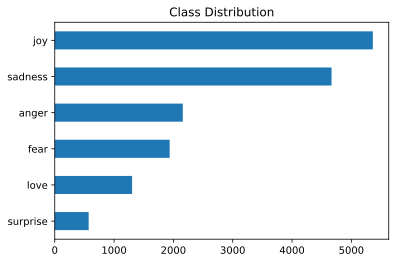

In [14]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Class Distribution')
plt.show()

The class `joy` has maximum number of samples while `love` and `surprise` are very rare. Our data is heavily imbalanced!

We can overcome this by doing oversampling or undersampling as suggested in the book. But they haven't done this for the sake of simplicity. That's why I will too follow the book 😎. You can check the <a href='https://imbalanced-learn.org/stable/'>Imbalanced-Learn Library</a> if you are interested to do so.

The maximum length of words DistilBert excepts is 512 tokens. This is known as *maximum context size*. Let's see if our data exceeds this limit:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


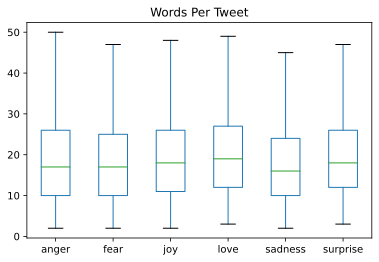

In [15]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

The maximum word length is around 50, which is significantly less than DistilBert's limit. So we're not required to do anything!

Extra:

But what if the length exceeds the limit?

1. You can truncate the sentence and only use the first 512 characters (or any other maximum context size). However, this will result in data loss.
2. If your dataset contains very rare sentences that exceed the limit, remove those samples (if you have less data, skip this step).

Now, we will convert this again dataframe into the format of 🤗 Datasets. This will make it suitable to use this data with 🤗 Transformers.

In [16]:
emotions.reset_format()

### **From Text to Tokens**

The DistilBert does not accept text in its raw form instead, it must be tokenized and encoded. When using RNN for text classification, I'm assuming you've already done this. Tokenization is a technique used in NLP to divide sentences into atomic units known as `tokens`.

The book also covers character tokenization and word tokenization, which I haven't written about. Instead, we'll skip ahead to `Subword Tokenization` and learn about `WordPiece` tokenization, which is used by BERT and DistilBert.

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [18]:
encoded_text = tokenizer('Tokenizing text is a core task in NLP')
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1999, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The tokenizer has maped every token to a unique number as you can see in `input_ids`. (Details about `attention_mask` will be discussed later)

Let's convert the `input_ids` back to tokens:

In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'in',
 'nl',
 '##p',
 '[SEP]']

The tokenizer has did following three things:

1. Lowercased the entire string
2. Added [CLS] and [SEP] special token to mark start and end of the string respectively.
3. The words 'Tokenizing' and 'NLP' has been split into two tokens because they are not common words.


Elaborating point (3):

In WordPiece Embedding if the tokenizer encounters a **unknown word** it splits it into several pieces which are available in our vocabulary. For example:

In [20]:
print(tokenizer.convert_ids_to_tokens(tokenizer('embed').input_ids))
print(tokenizer.convert_ids_to_tokens(tokenizer('embedded').input_ids))
print(tokenizer.convert_ids_to_tokens(tokenizer('embedding').input_ids))
print(tokenizer.convert_ids_to_tokens(tokenizer('embeds').input_ids))

['[CLS]', 'em', '##bed', '[SEP]']
['[CLS]', 'embedded', '[SEP]']
['[CLS]', 'em', '##bed', '##ding', '[SEP]']
['[CLS]', 'em', '##bed', '##s', '[SEP]']


The word embed, embedding, and embeds weren't present in the vocabulary that's why it split it into the words which were.

What's the '##'?

The '##' you see are nothing fancy. It is just there to tell the word preceeding is not a whitespace and any word that preceed it should be merged together.

In [21]:
words = tokenizer.convert_ids_to_tokens(tokenizer('embedding').input_ids)
print(words)
print(tokenizer.convert_tokens_to_string(words))

['[CLS]', 'em', '##bed', '##ding', '[SEP]']
[CLS] embedding [SEP]


As you can see the the words which has '##' and the word preceeding it has been joint together.

For more information on WordPiece: https://youtu.be/zJW57aCBCTk?t=428

You can also access some metadata about the tokenizer. Like the size of vocabulary:

In [22]:
print('The vocabulary size is:', tokenizer.vocab_size)

The vocabulary size is: 30522


In [23]:
print('Maximum context size:', tokenizer.model_max_length)

Maximum context size: 512


In [24]:
print('Name of the fields, model need in the forward pass:', tokenizer.model_input_names)

Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


#### **Tokenizing the whole dataset**

Let's tokenize our entire dataset now

In [25]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

The `padding=True` will pad the tokens with the longest sentence in the batch and the `truncation=True` will truncate the sentence to the model's maximum context size (remember, it was 512 in our case)

In [26]:
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [27]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
emotions_encoded['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

### **Training Text Classifier**

We can use DistilBert to train a text classifier in two ways.

1. Feature Extraction

For every input, the DistilBert output hidden states (features). Then we can create a simple neual network classifier which will take those hidden states as input and classify text. Note: We freeze the entire DistilBert when using this we don't update its parameters

2. Fine-tuning

We can train the entire DistilBert end-to-end. This will also update the DistilBert parameters

#### **1. Training as a Feature Extractor**

In [29]:
import torch
import torch.nn as nn

Let's load the DistilBert Model now,

In [30]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Let's do a forward pass on a test sample

In [31]:
text = "this is a test"
sample_inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n"
      f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])
Tokenized text: ['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


We will place all the tensors on the same device and generate the feature vector for the above sample text,

In [32]:
inputs = {k:v.to(device) for k,v in sample_inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [33]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

As you can see, the first two axes have the same shape as our input `(1, 6)`, however the last axis has the shape 768. Those are feature vectors :-)

However, we only want a single feature vector for each sentence, yet DistilBert has provided us a feature vector for each word/token in the sentence. Therefore, it is common practice in classification tasks to extract the feature vector from the [CLS] token, which is the first token in every sentence.

This is very straight forward:

In [34]:
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

Yes, that's all! In a similar manner, we will build feature vectors for each sentence.

Our feature vector should be `(1000, 768)` if we have 1000 sentences.

Let's create feature vector for all sentence in our dataset,

In [35]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
    if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

The DistilBert except input as pytorch tensor so let's convert the list to tensor,

In [36]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [37]:
print(type(emotions_encoded['train']['input_ids']))

<class 'torch.Tensor'>


It's done 🤗😎

Now, let's extract the hidden states by `extract_hidden_states()` function across all the train-test-val split by `.map()`.

In [38]:
emotions_hidden = emotions_encoded.map(
    extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [39]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

Now there's one more column known as `hidden state` in our dataset that's the feature vector which will be used to train the text classifier.

Let's make X_train, X_valid, y_train, y_valid:

In [40]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(16000, 768) (2000, 768)


Let's visualize the `X_train`. But it is 768 dimension that's why we will use PCA to first reduce the dimension to 2D and then plot it with matplotlib

Change: In the book, they used <a href='https://pypi.org/project/umap-learn/'>umap</a> to reduce dimension, however due to an installation error, I am switching to PCA, which comes packed with scikit learn.

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(16000, 2)

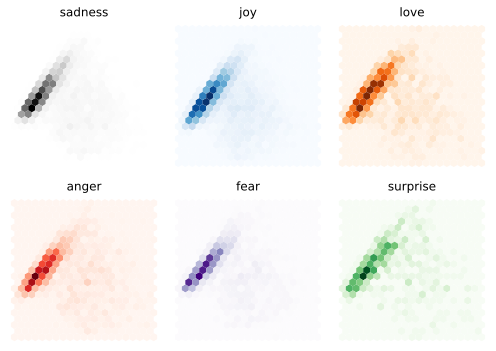

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(7, 5))
ax = ax.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].hexbin(x_2d_sub[:, 0], x_2d_sub[:, 1], cmap=cmap, gridsize=20, linewidths=(0,))
    ax[i].set_title(label)
    ax[i].set_axis_off()

plt.tight_layout()
plt.show()

Cool, right?

Now, let's build a classifier with LogisticRegression,

In [43]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

On the validation set, it achieved 63% accuracy. Not bad for a classifier that has to differentiate between six classes.

If we train our data on a `Dummy Classifier` which predicts the most frequent class or by random this is the accuracy:

In [44]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent") # Predict the most frequent
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

The Dummy classifier has a 35% accuracy, but our model has a far higher accuracy of 63%, proving that our model is not simply guessing the most frequent class.

Let's plot the confusion matrix to investigate the relationship between the true and predicted labels,

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

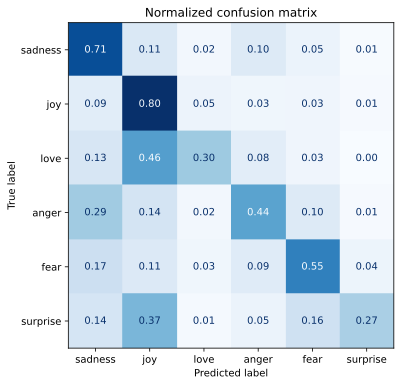

In [46]:
y_pred = lr_clf.predict(X_valid)
plot_confusion_matrix(y_pred, y_valid, labels)

1. Our model has classified `love` and `surprise` as `joy` several times.
2. `anger` and `fear` are also misclassified with `sandess`

But the overall performance looks good!

<a id='fine-tune-distilbert'></a>
### **Fine-Tuning DistilBert**

How Fine-Tuning Works?

In the last example, we simply used DistilBert's hidden states and fed them into Logistic Regression for classification, but sometimes your classification data is unsuitable for the model, resulting in poor performance. This is where fine-tuning comes into play, we may train the model (in our case, DistilBert) from start to finish to **adapt** to our dataset, which will significantly enhance accuracy. In short, you will *fine-tune* a previously trained model to your task.

Flow:

  Input --> DistilBert --> Classification Head --> Output

Step one is to load DistilBert but this time with <span style='font-family: monospace'>AutoModelForSequenceClassification</span>

This model already has a classification head on top of the pretrained model, so there is no need to develop one from scratch.

In [47]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

Now, let's create a `compute_metrics()` function which will return the F1 score and accuracy score. This function will receive an <span style='font-family: monospace'>EvalPrediction</span> object which has predictions and label_ids attributes which we will use to calculate score

In [48]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Now, let's define the `Trainer` but before that we will login to HuggingFace account which will later help us to push our model to the hub and share it with community

In [49]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


We will also create `TrainingArguments` class which will contain all the training parameters which makes it easy to control this information and have fine-grained control over trainining and evaluation

In [52]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

Let's start the training,

In [53]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

trainer.train()

Cloning https://huggingface.co/pritish/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.842200,0.332071,0.901000,0.896762
2,0.255900,0.217530,0.923500,0.923334


TrainOutput(global_step=500, training_loss=0.5490236968994141, metrics={'train_runtime': 241.35, 'train_samples_per_second': 132.588, 'train_steps_per_second': 2.072, 'total_flos': 720342861696000.0, 'train_loss': 0.5490236968994141, 'epoch': 2.0})

92% accuracy which is much higher than our previous model!

Let's visualize the confusion matrix for more details,

In [54]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [55]:
preds_output.metrics

{'test_accuracy': 0.9235,
 'test_f1': 0.9233337201115797,
 'test_loss': 0.21753039956092834,
 'test_runtime': 5.1331,
 'test_samples_per_second': 389.625,
 'test_steps_per_second': 6.234}

In [57]:
y_preds = np.argmax(preds_output.predictions, axis=1)

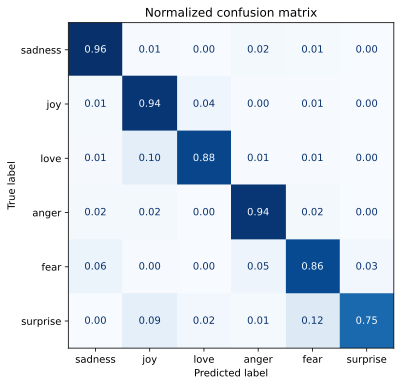

In [58]:
plot_confusion_matrix(y_preds, y_valid, labels)

Much better XD

This is why Fine-tuning is a very powerful technique 💪

I hope you liked this notebook.
<br><br><br>
Time for some self-promotion 😁:

YouTube: https://www.youtube.com/channel/UCQ9F_R0AOwuqipFKNdtTJ2g

GitHub: https://github.com/pritishmishra703

Twitter: https://twitter.com/Pritish88951762